## Analysis

See 2020_03_12_schwartz_klarna.pdf for a condensed summary of results.

1. Data
2. Test/Train Split
3. Pipeline
    1. Subset.OneHot.FlagMissingness.ImputeMissingness
    2. RF
4. Anomoly Detection (QC)
    1. Isolation Forest
    2. Productionalize
5. Grid Search
    1. Generalizability
    2. Out of Sample Performance
    3. Cost-Benefit Matrix
    4. Productionalize
6. Batch Predict
7. Extrapolation (QC)
    1. Muilticollinearity
    2. Propensity Scores
    3. Covariate Balance
8. Scratch Work
    1. Propensity Scores V2
    2. Propensity Scores V3   


In [1]:
# Misc.
from datetime import date
import matplotlib.pyplot as plt
import pickle 
#import importlib
#importlib.reload(custom_pipeline)

# Pipelining/Extrapolation
from custom_pipeline import subsetDataFrame,\
                            oneHotEncoder,\
                            addMissingnessIndicators,\
                            makeMissingnessMedian,\
                            thresholdedRF
import pandas as pd
pd.set_option("display.max_columns", 101)
pd.set_option("display.max_rows", 201)
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, IsolationForest 

# Tuning
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer,\
                            recall_score, precision_score, accuracy_score

# Balance
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pymatch.Matcher import Matcher
from scipy.stats import kstest

# Scratch
from causalinference import CausalModel
from statsmodels.discrete.discrete_model import Logit
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)


/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
DATE = date.today()

# 1. Data

In [3]:
PATH = '/Users/schwarls37/Downloads/ML Case Study/'
FILE = 'dataset.csv'
DATA = pd.read_csv(PATH+FILE, sep=';')
DATA.shape

(99976, 43)

In [4]:
FEATURES = DATA.columns.tolist()[2:]
CATEGORICALS = [
    'account_status',
    'account_worst_status_0_3m',
    'account_worst_status_12_24m',
    'account_worst_status_3_6m',
    'account_worst_status_6_12m',
    'merchant_category', 
    'merchant_group',
    'name_in_email',
    'status_last_archived_0_24m',
    'status_2nd_last_archived_0_24m',
    'status_3rd_last_archived_0_24m',
    'status_max_archived_0_6_months',
    'status_max_archived_0_12_months',
    'status_max_archived_0_24_months',
    'worst_status_active_inv'
]
NON_CATEGORICALS = [f for f in FEATURES if f not in CATEGORICALS]

# 2. Test/Train Split

In [7]:
kp_labeled = ~DATA.default.isna()
DATA_LABELED = DATA[kp_labeled]
kp_test = DATA_LABELED.sample(n=39976).index
kp_test = DATA_LABELED.sample(n=14976).index
kp_test = DATA_LABELED.index.isin(kp_test)
DATA_TEST = DATA_LABELED[kp_test]
DATA_TRAIN = DATA_LABELED[~kp_test]
DATA_TRAIN.shape,DATA_TEST.shape

((75000, 43), (14976, 43))

# 3. Pipeline

In [9]:
SDF = subsetDataFrame(FEATURES)
SDF.fit(DATA)
DATA_SDF = SDF.transform(DATA)

OHE = oneHotEncoder(CATEGORICALS)
OHE.fit(DATA_SDF)
DATA_SDF_OHE = OHE.transform(DATA_SDF)

AMI = addMissingnessIndicators(NON_CATEGORICALS)
AMI.fit(DATA_SDF_OHE)
DATA_SDF_OHE_AMI = AMI.transform(DATA_SDF_OHE)

MMM = makeMissingnessMedian()    
MMM.fit(DATA_SDF_OHE_AMI)
DATA_SDF_OHE_AMI_MMM = MMM.transform(DATA_SDF_OHE_AMI)

SDF = subsetDataFrame(FEATURES)
OHE = oneHotEncoder(CATEGORICALS)
AMI = addMissingnessIndicators(NON_CATEGORICALS)
MMM = makeMissingnessMedian()
TRF = thresholdedRF(positive_class_rate=DATA_TRAIN.default.sum()/DATA_TRAIN.shape[0],
                    min_samples_leaf = 1, n_estimators=100, max_features='auto')

rf_pipeline = Pipeline([('subsetDataFrame',SDF), 
                        ('oneHotEncoder',OHE), 
                        ('addMissingnessIndicators',AMI), 
                        ('makeMissingnessMedian',MMM), 
                        ('thresholdedRF',TRF)])

rf_pipeline.fit(DATA_TRAIN, DATA_TRAIN.default)
confusion_matrix(DATA_TRAIN.default, rf_pipeline.predict(DATA_TRAIN))

array([[67486,  6430],
       [    0,  1084]])

# 4. Anomoly Detection (QC)

(array([   38.,   271.,   983.,  2610.,  5485.,  9687., 16026., 22448.,
        12621.,  4831.]),
 array([-0.08126426, -0.05849929, -0.03573433, -0.01296937,  0.0097956 ,
         0.03256056,  0.05532553,  0.07809049,  0.10085546,  0.12362042,
         0.14638538]),
 <a list of 10 Patch objects>)

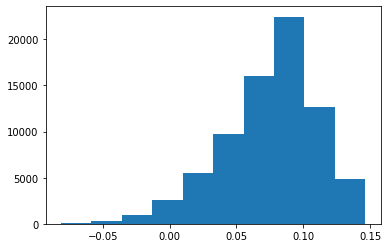

In [10]:
DATA_TRAIN_ISOF = rf_pipeline.transform(DATA_TRAIN)
isoF = IsolationForest(max_samples=100)
isoF.fit(DATA_TRAIN_ISOF)
anomoly_score = isoF.decision_function(DATA_TRAIN_ISOF)

plt.hist(anomoly_score)

# 4. Anomoly Detection (QC): Productionalize

In [1106]:
pickle.dump(rf_pipeline.transform(DATA_TRAIN)[:0], open('/Users/schwarls37/TAKEHOMES/fraud/webserver/isoF_X.pkl', 'wb'))
pickle.dump(isoF, open('/Users/schwarls37/TAKEHOMES/fraud/webserver/isoF.pkl', 'wb'))
pickle.dump(anomoly_score, open('/Users/schwarls37/TAKEHOMES/fraud/webserver/isoF_pop.pkl', 'wb'))

# 5. Grid Search

In [14]:
pars={'thresholdedRF__positive_class_rate': [DATA_TRAIN.default.sum()/DATA_TRAIN.shape[0]], 
      'thresholdedRF__max_features': [4,7,10,15,20],
      'thresholdedRF__min_samples_leaf': [int(i) for i in np.linspace(100,200,6)]}
#previously:
#["log2", "sqrt", 1/5, 1/2, None][:2] 
#[int(round(i+1)) for i in DATA_TRAIN.default.sum()*np.logspace(-3,0,11)][3:7]}
# thresholdedRF__min_samples_leaf : coarse leaves, increasing fractions of positive class size

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

# StratifiedKFold persists class (im)balance
# which is needed since TRF is based on this
TRF_GridSearch = GridSearchCV(estimator=rf_pipeline, param_grid=pars, 
                              scoring=scorers, refit='recall_score', 
                              cv=StratifiedKFold(n_splits=5), 
                              verbose=10, n_jobs=-1,                             
                              return_train_score=True)
TRF_GridSearch.fit(DATA_TRAIN, DATA_TRAIN.default)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=100, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV] thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=100, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV] thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=100, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV] thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=100, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=100, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.03515346181299072, recall_score=0.9078341013824884, accuracy_score=0.6382, total=  24.6s
[CV] thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=100, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=4, thresholdedRF

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.7min


[CV]  thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=120, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.036751523843671564, recall_score=0.9447004608294931, accuracy_score=0.641, total=  22.3s
[CV] thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=120, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=120, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.03587206220180244, recall_score=0.9354838709677419, accuracy_score=0.6353576428238118, total=  22.6s
[CV]  thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=120, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.03488372093023256, recall_score=0.8986175115207373, accuracy_score=0.6388666666666667, total=  21.7s
[CV] thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=140, thresholdedRF__positive_class_rate=0.014453333333333334 
[C

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.5min


[CV]  thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=120, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.036418015482054894, recall_score=0.9583333333333334, accuracy_score=0.6342422828188546, total=  21.7s
[CV] thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=140, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=140, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.03550401427297056, recall_score=0.9170506912442397, accuracy_score=0.6384241050596627, total=  21.6s
[CV] thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=160, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=140, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.03430592396109638, recall_score=0.8940092165898618, accuracy_score=0.6344, total=  20.5s
[

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.9min


[CV]  thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=160, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.03457911281872162, recall_score=0.9124423963133641, accuracy_score=0.6302, total=  20.5s
[CV] thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=180, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=160, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.03517241379310345, recall_score=0.9400921658986175, accuracy_score=0.6260666666666667, total=  20.3s
[CV] thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=180, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=160, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.034593861285399354, recall_score=0.9444444444444444, accuracy_score=0.619641309420628, total=  20.4s
[C

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.7min


[CV]  thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=180, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.03519458544839255, recall_score=0.9629629629629629, accuracy_score=0.6193079538635909, total=  22.8s
[CV] thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=200, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=200, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.03454231433506045, recall_score=0.9216589861751152, accuracy_score=0.6262249183387775, total=  23.6s
[CV] thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=200, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=4, thresholdedRF__min_samples_leaf=200, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.03467799009200283, recall_score=0.9032258064516129, accuracy_score=0.6348666666666667, tota

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.1min


[CV]  thresholdedRF__max_features=7, thresholdedRF__min_samples_leaf=100, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.03761467889908257, recall_score=0.9447004608294931, accuracy_score=0.6495333333333333, total=  23.1s
[CV] thresholdedRF__max_features=7, thresholdedRF__min_samples_leaf=120, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=7, thresholdedRF__min_samples_leaf=120, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.03641908862576247, recall_score=0.9354838709677419, accuracy_score=0.6410239317378842, total=  24.7s
[CV] thresholdedRF__max_features=7, thresholdedRF__min_samples_leaf=120, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=7, thresholdedRF__min_samples_leaf=100, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.037182695745441544, recall_score=0.9629629629629629, accuracy_score=0.6403760250683379, tot

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.9min


[CV]  thresholdedRF__max_features=7, thresholdedRF__min_samples_leaf=140, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.03549438609199566, recall_score=0.9032258064516129, accuracy_score=0.6435333333333333, total=  27.0s
[CV] thresholdedRF__max_features=7, thresholdedRF__min_samples_leaf=160, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=7, thresholdedRF__min_samples_leaf=140, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.037198330611504266, recall_score=0.9447004608294931, accuracy_score=0.6454666666666666, total=  27.4s
[CV] thresholdedRF__max_features=7, thresholdedRF__min_samples_leaf=160, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=7, thresholdedRF__min_samples_leaf=140, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.036527263102170464, recall_score=0.9583333333333334, accuracy_score=0.6353756917127809, to

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 11.4min


[CV]  thresholdedRF__max_features=7, thresholdedRF__min_samples_leaf=180, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.036587542388006426, recall_score=0.9447004608294931, accuracy_score=0.6393333333333333, total=  24.2s
[CV] thresholdedRF__max_features=7, thresholdedRF__min_samples_leaf=200, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=7, thresholdedRF__min_samples_leaf=180, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.03683929524826481, recall_score=0.9583333333333334, accuracy_score=0.6385759050603373, total=  23.8s
[CV] thresholdedRF__max_features=7, thresholdedRF__min_samples_leaf=200, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=7, thresholdedRF__min_samples_leaf=200, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.03592388404766139, recall_score=0.9308755760368663, accuracy_score=0.6376241583894408, tot

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 13.6min


[CV] thresholdedRF__max_features=10, thresholdedRF__min_samples_leaf=120, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=10, thresholdedRF__min_samples_leaf=100, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.039171374764595104, recall_score=0.9629629629629629, accuracy_score=0.6593106207080472, total=  34.2s
[CV] thresholdedRF__max_features=10, thresholdedRF__min_samples_leaf=120, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=10, thresholdedRF__min_samples_leaf=120, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.037838855421686746, recall_score=0.9262672811059908, accuracy_score=0.6582227851476569, total=  32.6s
[CV] thresholdedRF__max_features=10, thresholdedRF__min_samples_leaf=120, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=10, thresholdedRF__min_samples_leaf=120, thresholdedRF__positive_clas

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 16.7min


[CV]  thresholdedRF__max_features=10, thresholdedRF__min_samples_leaf=160, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.03568814055636896, recall_score=0.8986175115207373, accuracy_score=0.6472666666666667, total=  23.7s
[CV] thresholdedRF__max_features=10, thresholdedRF__min_samples_leaf=180, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=10, thresholdedRF__min_samples_leaf=160, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.037347422116961196, recall_score=0.9447004608294931, accuracy_score=0.6469333333333334, total=  23.4s
[CV] thresholdedRF__max_features=10, thresholdedRF__min_samples_leaf=180, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=10, thresholdedRF__min_samples_leaf=160, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.03758169934640523, recall_score=0.9583333333333334, accuracy_score=0.6459763984265617

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 19.4min


[CV]  thresholdedRF__max_features=15, thresholdedRF__min_samples_leaf=100, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.04210301346441547, recall_score=0.9078341013824884, accuracy_score=0.6998866742217186, total=  29.6s
[CV] thresholdedRF__max_features=15, thresholdedRF__min_samples_leaf=100, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=15, thresholdedRF__min_samples_leaf=100, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.04214720067100021, recall_score=0.9262672811059908, accuracy_score=0.6944, total=  29.5s
[CV] thresholdedRF__max_features=15, thresholdedRF__min_samples_leaf=120, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=15, thresholdedRF__min_samples_leaf=100, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.038557732388495206, recall_score=0.8525345622119815, accuracy_score=0.6903333333333334, total=  33

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 23.0min


[CV]  thresholdedRF__max_features=15, thresholdedRF__min_samples_leaf=160, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.04029376736800318, recall_score=0.9354838709677419, accuracy_score=0.6767548830077995, total=  27.5s
[CV] thresholdedRF__max_features=15, thresholdedRF__min_samples_leaf=160, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=15, thresholdedRF__min_samples_leaf=160, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.03934740882917467, recall_score=0.9447004608294931, accuracy_score=0.6655333333333333, total=  26.6s
[CV] thresholdedRF__max_features=15, thresholdedRF__min_samples_leaf=180, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=15, thresholdedRF__min_samples_leaf=160, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.03882538431217974, recall_score=0.9078341013824884, accuracy_score=0.6735333333333333,

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 25.8min


[CV]  thresholdedRF__max_features=20, thresholdedRF__min_samples_leaf=100, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.04346846846846847, recall_score=0.8894009216589862, accuracy_score=0.7152856476234918, total=  32.1s
[CV] thresholdedRF__max_features=20, thresholdedRF__min_samples_leaf=100, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=20, thresholdedRF__min_samples_leaf=100, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.04532130777903044, recall_score=0.9262672811059908, accuracy_score=0.7166666666666667, total=  31.9s
[CV] thresholdedRF__max_features=20, thresholdedRF__min_samples_leaf=120, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=20, thresholdedRF__min_samples_leaf=100, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.041638683680322364, recall_score=0.8571428571428571, accuracy_score=0.7125333333333334

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 30.2min


[CV]  thresholdedRF__max_features=20, thresholdedRF__min_samples_leaf=160, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.04004127966976264, recall_score=0.8940092165898618, accuracy_score=0.6884, total=  30.2s
[CV] thresholdedRF__max_features=20, thresholdedRF__min_samples_leaf=180, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=20, thresholdedRF__min_samples_leaf=160, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.04220183486238532, recall_score=0.9539170506912442, accuracy_score=0.6861333333333334, total=  30.3s
[CV] thresholdedRF__max_features=20, thresholdedRF__min_samples_leaf=180, thresholdedRF__positive_class_rate=0.014453333333333334 
[CV]  thresholdedRF__max_features=20, thresholdedRF__min_samples_leaf=160, thresholdedRF__positive_class_rate=0.014453333333333334, precision_score=0.042291110654896324, recall_score=0.9537037037037037, accuracy_score=0.688312554170278, total=  30.

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 38.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('subsetDataFrame', subsetDataFrame(target_columns=['account_amount_added_12_24m', 'account_days_in_dc_12_24m', 'account_days_in_rem_12_24m', 'account_days_in_term_12_24m', 'account_incoming_debt_vs_paid_0_24m', 'account_status', 'account_worst_status_0_3m', 'account_worst_status_12_24m', 'ac...res='auto', min_samples_leaf=1, n_estimators=100,
       positive_class_rate=0.014453333333333334))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'thresholdedRF__positive_class_rate': [0.014453333333333334], 'thresholdedRF__max_features': [4, 7, 10, 15, 20], 'thresholdedRF__min_samples_leaf': [100, 120, 140, 160, 180, 200]},
       pre_dispatch='2*n_jobs', refit='recall_score',
       return_train_score=True,
       scoring={'precision_score': make_scorer(precision_score), 'recall_score': make_scorer(recall_score), 'acc

In [15]:
TRF_GridSearch.best_index_

7

In [16]:
TRF_GridSearch.cv_results_['params'][TRF_GridSearch.best_index_]


{'thresholdedRF__max_features': 7,
 'thresholdedRF__min_samples_leaf': 120,
 'thresholdedRF__positive_class_rate': 0.014453333333333334}

In [17]:
TRF_GridSearch.cv_results_['split0_train_recall_score'][TRF_GridSearch.best_index_],\
TRF_GridSearch.cv_results_['split1_train_recall_score'][TRF_GridSearch.best_index_],\
TRF_GridSearch.cv_results_['split2_train_recall_score'][TRF_GridSearch.best_index_],\
TRF_GridSearch.cv_results_['split3_train_recall_score'][TRF_GridSearch.best_index_],\
TRF_GridSearch.cv_results_['split4_train_recall_score'][TRF_GridSearch.best_index_],\


(0.9607843137254902,
 0.9550173010380623,
 0.9665513264129181,
 0.9561707035755479,
 0.9550691244239631)

In [19]:
TRF_GridSearch.cv_results_['mean_train_recall_score'][TRF_GridSearch.best_index_],\
TRF_GridSearch.cv_results_['mean_train_precision_score'][TRF_GridSearch.best_index_],\
TRF_GridSearch.cv_results_['mean_train_accuracy_score'][TRF_GridSearch.best_index_],


(0.9587185538351963, 0.037183138633527416, 0.6405866699045324)

In [20]:
TRF_GridSearch.cv_results_['std_train_recall_score'][TRF_GridSearch.best_index_],\
TRF_GridSearch.cv_results_['std_train_precision_score'][TRF_GridSearch.best_index_],\
TRF_GridSearch.cv_results_['std_train_accuracy_score'][TRF_GridSearch.best_index_],\


(0.00445261357901434, 0.00029565672619163855, 0.00203454465796533)

In [21]:
TRF_GridSearch.cv_results_['mean_test_recall_score'][TRF_GridSearch.best_index_],\
TRF_GridSearch.cv_results_['mean_test_precision_score'][TRF_GridSearch.best_index_],\
TRF_GridSearch.cv_results_['mean_test_accuracy_score'][TRF_GridSearch.best_index_],\


(0.9455876179097684, 0.036598230499787374, 0.6394666666666666)

In [22]:
TRF_GridSearch.cv_results_['std_test_recall_score'][TRF_GridSearch.best_index_],\
TRF_GridSearch.cv_results_['std_test_precision_score'][TRF_GridSearch.best_index_],\
TRF_GridSearch.cv_results_['std_test_accuracy_score'][TRF_GridSearch.best_index_],\


(0.02003617411389023, 0.0006504771597483457, 0.002289328328791217)

In [164]:
CM = confusion_matrix(DATA_TEST.default, TRF_GridSearch.best_estimator_.predict(DATA_TEST))

CM[1,1]/CM[1,:].sum(), CM[1,1]/CM[:,1].sum(), CM.diagonal().sum()/CM.sum()

(0.9215686274509803, 0.03466715839940992, 0.6493723290598291)

# 5. Grid Search: Cost-Benefit Matrix

- f: inaction: baseline
- t: action: impact
    - O: offended customer cost (-)
    - D: default losses avoided (+)

|   | f | t |
|---|---|---|
| F | 0 | O |
| T | 0 | D |



In [139]:
#account_amount_added_12_24m
#plt.plot((sorted(DATA_TRAIN.num_unpaid_bills[kp_default].dropna().values)))

In [138]:
kp_default = (DATA_TRAIN.default==1)

# O:
# FOR THE PURPOSES OF THIS EXERCISE LET US ASSUME
# (because I haven't noticed a better way to calculate this with the data I have)
customer_12_month_ave_value = DATA_TRAIN.sum_paid_inv_0_12m[~kp_default].mean()
# and that the reprocussion of wrongly calling 'default'
# on a customer who won't default is that 1 in 100 leave
# and that we take 1% commission on all sales
offended_customer_cost = -(1/100)*0.01*customer_12_month_ave_value
print('offended_customer_cost', offended_customer_cost)

# C:
# FOR THE PURPOSES OF THIS EXERCISE LET US ASSUME 
# (because I haven't noticed a better way to calculate this with the data I have)
default_losses_avoided = DATA_TRAIN.num_unpaid_bills[kp_default].mean()\
                         * DATA_TRAIN.avg_payment_span_0_12m[kp_default].mean()#max_paid_inv_0_12m?
print('default_losses_avoided', default_losses_avoided)


offended_customer_cost -3.9733761797175178
default_losses_avoided 158.31564378892813


In [142]:
CBM = np.array([[0,offended_customer_cost],[0,default_losses_avoided]])
CBM

array([[  0.        ,  -3.97337618],
       [  0.        , 158.31564379]])

0.023

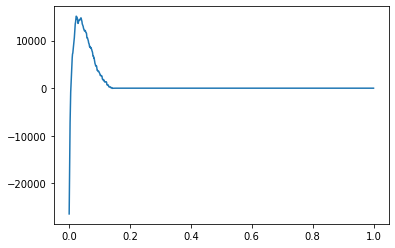

In [155]:
yhat = TRF_GridSearch.best_estimator_.predict_proba(DATA_TEST)[:,1]

grid_n = 1001
cost = np.zeros(grid_n)
grid = np.linspace(0,1,grid_n)
for i,t in enumerate(grid):
    cost[i] = (confusion_matrix(DATA_TEST.default, yhat>t)*CBM).sum()

plt.plot(grid, cost)
grid[cost.argmax()]

In [163]:
CM = confusion_matrix(DATA_TEST.default, yhat > grid[cost.argmax()])

CM[1,1]/CM[1,:].sum(), CM[1,1]/CM[:,1].sum(), CM.diagonal().sum()/CM.sum()

(0.7745098039215687, 0.05957767722473605, 0.8303952991452992)

In [178]:
TRF_GridSearch.best_estimator_.get_params()['thresholdedRF'].positive_class_rate = grid[cost.argmax()]
TRF_GridSearch.best_estimator_.get_params()['thresholdedRF__positive_class_rate']

0.023

# 5. Grid Search: Productionalize

In [181]:
pickle.dump(SDF.transform(DATA_TEST), open('/Users/schwarls37/TAKEHOMES/klarna/fraud/webserver/generate.pkl', 'wb'))
pickle.dump(TRF_GridSearch.best_estimator_, open('/Users/schwarls37/TAKEHOMES/klarna/fraud/webserver/pred.pkl', 'wb'))


# 6. Batch Predict

In [215]:
output = DATA[~kp_labeled].iloc[:,:2]
output.default = TRF_GridSearch.best_estimator_.predict_proba(DATA[~kp_labeled])[:,1]
output.columns = ['uuid','pd']
output.to_csv('/Users/schwarls37/TAKEHOMES/klarna/default_preds.csv', index=False)
output.head()

,uuid,pd
89976,6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7,0.004266
89977,f6f6d9f3-ef2b-4329-a388-c6a687f27e70,0.023530
89978,e9c39869-1bc5-4375-b627-a2df70b445ea,0.025881
89979,6beb88a3-9641-4381-beb6-c9a208664dd0,0.030191
89980,bb89b735-72fe-42a4-ba06-d63be0f4ca36,0.070996


# 7. Extrapolaton (QC): Multicollinearity

In [382]:
# 1. remove referrent
print('Referrent-based removal')
X = DATA_SDF_OHE_AMI_MMM.copy()
for c in CATEGORICALS:
    kp = X[[g for g in DATA_SDF_OHE_AMI_MMM.columns if c in g]].sum()
    rm = kp.index[kp.max()==kp].values[0]
    del X[rm]
    print('del',rm)

# 2. greedily remove VIF=INF and VIF>10
print('VIF-based removal')
#X['test'] = DATA.default.isna()
X_columns = X.columns
i = 0
VIFlist = {}
for c in X_columns:
    VIF = variance_inflation_factor(X.values.astype(float), i)
    if np.isinf(VIF):
        del X[c]
        print('del inf',c)
    elif np.isnan(VIF):
        del X[c]
        print('del nan',c)
    elif VIF > 5:
        del X[c]
        print('del',c, VIF)        
    else:
        VIFlist[X.columns[i]] = VIF
        print(X.columns[i], VIF)
        i += 1


Referrent-based removal
del account_status:nan
del account_worst_status_0_3m:nan
del account_worst_status_12_24m:nan
del account_worst_status_3_6m:nan
del account_worst_status_6_12m:nan
del merchant_category:Diversified entertainment
del merchant_group:Entertainment
del name_in_email:F+L
del status_last_archived_0_24m:1.0
del status_2nd_last_archived_0_24m:1.0
del status_3rd_last_archived_0_24m:1.0
del status_max_archived_0_6_months:1.0
del status_max_archived_0_12_months:1.0
del status_max_archived_0_24_months:1.0
del worst_status_active_inv:nan
VIF-based removal


/anaconda3/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


del inf account_status:1.0
account_status:2.0 1.4020054449228423
account_status:3.0 1.0201021721600583
account_status:4.0 1.4350811339294816
del account_worst_status_0_3m:1.0 14.16734236659353
account_worst_status_0_3m:2.0 1.9662512247368813
account_worst_status_0_3m:3.0 1.1652464529391986
account_worst_status_0_3m:4.0 1.317303749035385
del account_worst_status_12_24m:1.0 5.113398689180979
account_worst_status_12_24m:2.0 2.11246952929674
account_worst_status_12_24m:3.0 2.757875866831219
account_worst_status_12_24m:4.0 3.608604433635258
del account_worst_status_3_6m:1.0 19.758682945691806
account_worst_status_3_6m:2.0 1.777877718106523
account_worst_status_3_6m:3.0 1.191079523479431
account_worst_status_3_6m:4.0 1.4951431548222416
account_worst_status_6_12m:1.0 4.819890693205651
account_worst_status_6_12m:2.0 2.894868244569362
account_worst_status_6_12m:3.0 1.2838916361656136
account_worst_status_6_12m:4.0 1.412680591548248
del inf merchant_category:Adult Shoes & Clothing
del inf mercha

/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1388: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


del nan merchant_category:nan
merchant_group:Automotive Products 1.168362484094076
merchant_group:Children Products 3.596525724975083
merchant_group:Clothing & Shoes 3.999057910948621
merchant_group:Electronics 1.711978972326237
merchant_group:Erotic Materials 1.2266778048325773
merchant_group:Food & Beverage 1.2772344201657346
del merchant_group:Health & Beauty 8.846670330788168
del merchant_group:Home & Garden 5.606787505060269
merchant_group:Intangible products 1.8426458327421307
merchant_group:Jewelry & Accessories 1.165009425249561
merchant_group:Leisure, Sport & Hobby 2.8709045440588135
del nan merchant_group:nan
name_in_email:F 1.2849880966937477
name_in_email:F1+L 1.1814595470509934
name_in_email:Initials 1.0021163183199362
name_in_email:L 1.0362899352537045
name_in_email:L1+F 1.39022173827306
name_in_email:Nick 1.2069912151239683
name_in_email:no_match 1.4231996927951538
del nan name_in_email:nan
del inf status_last_archived_0_24m:0.0
status_last_archived_0_24m:2.0 1.828244869

112

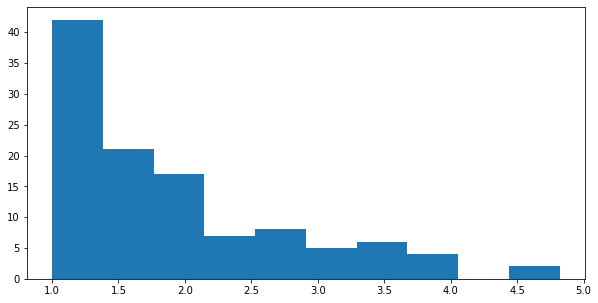

In [383]:
plt.hist(VIFlist.values())
len(VIFlist)

# 7. Extrapolaton (QC): Propensity Scores

In [584]:
X = DATA_SDF_OHE_AMI_MMM[list(VIFlist.keys())].astype(float)
X_columns = X.columns
X.columns = ['X'+str(i) for i in range(X.shape[1])]

kp_test = DATA.default.isna()
test = X[kp_test] 
control = X[~kp_test] 
test['test'] = 1
control['test'] = 0

for c in X.columns:
    if control[c].sum()==0 or test[c].sum()==0:
        del X[c]
        del test[c]
        del control[c]
        

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Formula:
test ~ X0+X3+X4+X5+X6+X7+X8+X9+X10+X11+X12+X13+X14+X15+X16+X17+X18+X19+X20+X21+X22+X23+X24+X25+X27+X28+X29+X30+X31+X32+X33+X34+X35+X36+X37+X38+X39+X40+X41+X42+X43+X44+X45+X46+X47+X48+X49+X50+X51+X52+X53+X55+X56+X57+X58+X59+X60+X61+X62+X63+X64+X65+X66+X67+X68+X69+X70+X71+X72+X73+X75+X76+X77+X78+X79+X80+X81+X82+X83+X84+X85+X86+X87+X88+X89+X90+X91+X92+X93+X94+X95+X96+X97+X98+X99+X100+X101+X102+X103+X104+X105+X106+X107+X108+X109+X110+X111
n majority: 89976
n minority: 10000
Fitting 1 (Unbalanced) Model...

Accuracy 90.0


/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


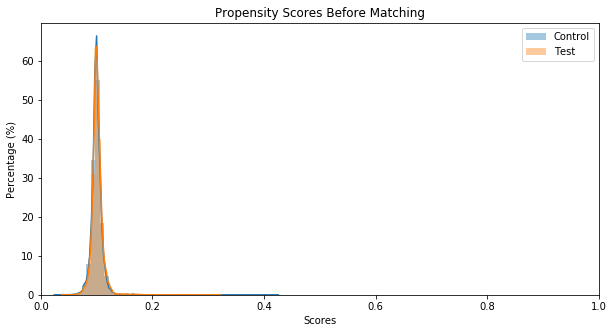

In [585]:
m = Matcher(test.copy(), control.copy(), yvar="test", exclude=[]) #'X'+str(i) for i in range(102)
m.fit_scores(balance=False)#balance=True, nmodels=10)
m.predict_scores()
m.plot_scores()
#dir(m)
#m.models[0].summary()

# 7. Extrapolaton: Covariate Balance

In [568]:
ks_stats = {}
#https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Two-sample_Kolmogorov%E2%80%93Smirnov_test
ks_pointOfive_threshold = 1.358 * np.sqrt((test.shape[0]+control.shape[0])/(test.shape[0]*control.shape[0]))

for i,c in enumerate(X):    
    ks_stats[X_columns[i]] = stats.ks_2samp(test[c],control[c]).statistic/ks_pointOfive_threshold

ks_stats = pd.DataFrame(ks_stats, index=[0]).T
ks_stats.columns=['KS_Stat']
ks_stats = ks_stats.sort_values(by='KS_Stat')#, ascending=False)

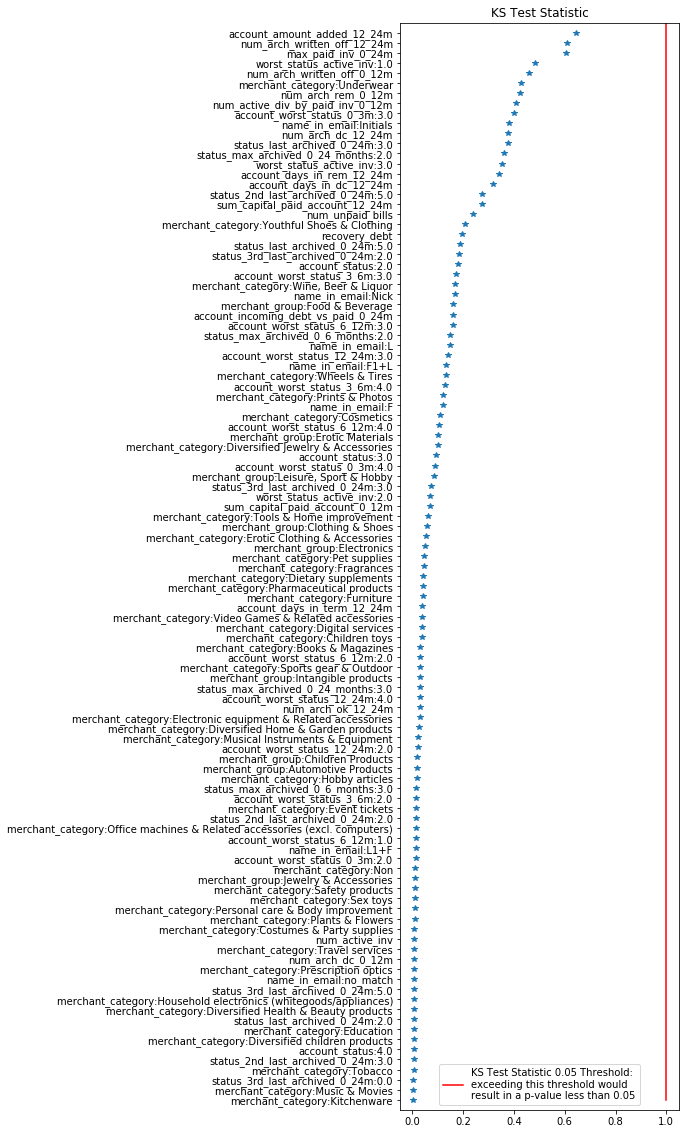

In [583]:
plt.figure(figsize=(5,20))
plt.plot(ks_stats, range(ks_stats.shape[0]), '*')
plt.plot([1]*2, [0,ks_stats.shape[0]],'r', label='KS Test Statistic 0.05 Threshold:\nexceeding this threshold would\nresult in a p-value less than 0.05')
plt.legend()
plt.ylim([-1,ks_stats.shape[0]])
plt.title('KS Test Statistic')
_=plt.yticks(range(ks_stats.shape[0]),ks_stats.index)

# 8. Scratch Work

In [588]:
causal = CausalModel(DATA['default'].isna().astype(int), DATA['default'].isna().astype(int), XX.values)
causal.est_propensity_s()

print(causal.propensity)

/anaconda3/lib/python3.6/site-packages/causalinference/core/summary.py:110: RuntimeWarning: invalid value encountered in true_divide
  return (mean_t-mean_c) / np.sqrt((sd_c**2+sd_t**2)/2)


KeyboardInterrupt: 

In [586]:
XX = X
XX = sm.add_constant(XX)    
logistic = Logit(exog=XX, endog=DATA['default'].isna().astype(int))
result = logistic.fit()
result.summary()#result.summary2()


Optimization terminated successfully.
         Current function value: 0.324667
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                99976
Model:                          Logit   Df Residuals:                    99868
Method:                           MLE   Df Model:                          107
Date:                Tue, 10 Mar 2020   Pseudo R-squ.:                0.001441
Time:                        22:14:34   Log-Likelihood:                -32459.
converged:                       True   LL-Null:                       -32506.
                                        LLR p-value:                    0.8167
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2168      0.053    -42.127      0.000      -2.320      -2.114
X0             0.2021      0.088      2.292      0.022       0.029       0.375
X3            -0.0547      0.058     -0.937      0.349      -0.169       0.060
X4            -0.0048      0.169     -0.029      0.977      -0.337       0.327
X5            -0.4060      0.390     -1.041      0.298      -1.170       0.358
X6            -0.0946      0.054     -1.759      0.079      -0.200       0.011
X7            -0.2214      0.184     -1.206      0.228      -0.581       0.138
X8            -0.1188      0.388     -0.306      0.759      -0.879       0.641
X9            -0.0183      0.056     -0.325      0.745      -0.129       0.092
X10            0.0895      0.156      0.573      0.567      -0.217       0.396
X11            0.4531      0.315      1.438      0.150      -0.164       1.071
X12            0.0534      0.044      1.206      0.228      -0.033       0.140
X13            0.0387      0.065      0.593      0.553      -0.089       0.166
X14            0.0192      0.147      0.131      0.896      -0.269       0.307
X15           -0.3895      0.302     -1.291      0.197      -0.981       0.202
X16           -0.0222      0.039     -0.571      0.568      -0.099       0.054
X17           -0.2190      0.175     -1.254      0.210      -0.561       0.123
X18           -0.0663      0.137     -0.484      0.628      -0.335       0.202
X19           -0.4236      0.332     -1.278      0.201      -1.073       0.226
X20            0.0550      0.062      0.894      0.371      -0.066       0.176
X21            0.0226      0.238      0.095      0.924      -0.444       0.489
X22            0.0852      0.116      0.732      0.464      -0.143       0.313
X23           -0.0750      0.131     -0.573      0.567      -0.331       0.181
X24            0.1040      0.447      0.233      0.816      -0.772       0.980
X25            0.0612      0.107      0.572      0.567      -0.149       0.271
X27           -0.3249      0.131     -2.480      0.013      -0.582      -0.068
X28            0.0861      0.377      0.228      0.820      -0.654       0.826
X29            0.5475      0.781      0.701      0.483      -0.983       2.078
X30            0.1156      0.178      0.650      0.516      -0.233       0.464
X31           -0.2233      0.192     -1.166      0.244      -0.599       0.152
X32            0.0280      0.120      0.232      0.816      -0.208       0.264
X33            0.4089      0.292      1.401      0.161      -0.163       0.981
X34            0.5320      0.282      1.887      0.059      -0.020       1.084
X35            0.1698      0.275      0.616      0.538      -0.370       0.710
X36           -0.1351      0.431     -0.314      0.754      -0.979       0.709
X37           -0.0786      0.412     -0.191      0.849      -0.887       0.730
X38           -0.0089      0.756     -0.012      0.991      -1.491       1.474
X39            0.0914      0.169      0.542      0.588      -0.239       0.422
X4

In [ ]:
plt.plot(causal.propensity['fitted'],result.predict(), '.')